In [57]:
# import des librairies dont nous aurons besoin
import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import *
from sklearn.metrics import accuracy_score, f1_score, classification_report 
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression


# Ouverture du dataframe et train test split 

In [7]:
df_clean = pd.read_csv("df_clean.csv")
df_clean

,State,NAICS,Term,FranchiseCode,UrbanRural,GrAppv,Default
0,IN,45,84,1,0,6000000,0
1,IN,72,60,1,0,4000000,0
2,IN,62,180,1,0,28700000,0
3,OK,0,60,1,0,3500000,0
4,FL,0,240,1,0,22900000,0
...,...,...,...,...,...,...,...
897149,OH,45,60,1,0,7000000,0
897150,OH,45,60,1,0,8500000,0
897151,CA,33,108,1,0,30000000,0
897152,HI,0,60,1,0,7500000,1


In [8]:
X = df_clean.drop('Default', axis=1)
y = df_clean['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
numeric_features = ["Term", "FranchiseCode", "UrbanRural", "GrAppv"]
categorial_features = [ "State", "NAICS"]

# Pipeline

In [9]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
scale_one_hot = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), categorial_features),
    ('standard_scaler', StandardScaler(), numeric_features)  ])
    

# XGBoost

In [10]:
scale_pos_weight = len(df_clean[df_clean['Default'] == 0]) / len(df_clean[df_clean['Default'] == 1])
objective = 'binary:logistic',
tree_method = 'gpu_hist',
scale_pos_weight = scale_pos_weight,
subsample = 0.8,
colsample_bytree = 0.8,
max_depth = 10,
learning_rate = 0.01,
n_estimators = 1000,
silent = 0

In [11]:
## XGBClassifier
model_xgb = make_pipeline(scale_one_hot,XGBClassifier(seed = 42, enable_categorical=True, tree_method='hist'))

In [12]:
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['State', 'NAICS']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Term', 'FranchiseCode',
                                                   'UrbanRural', 'GrAppv'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=Non...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [21]:
predictions = model_xgb.predict(X_train)
# accuracy = model_xgb.score(X_test, y_test)

In [22]:
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96    628658
           1       0.85      0.79      0.82    133922

    accuracy                           0.94    762580
   macro avg       0.90      0.88      0.89    762580
weighted avg       0.94      0.94      0.94    762580



In [23]:
cross_val_score(model_xgb,X_train, y_train, scoring = 'f1_macro').mean()

0.8823136877277138

In [15]:
from sklearn.model_selection import cross_val_predict
pred_xg = cross_val_predict(model_xgb,X_train,y_train, cv=5,  verbose=0)
print(classification_report(y_train, pred_xg))
# on fait une prediction sur le y train 

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    628658
           1       0.84      0.77      0.80    133922

    accuracy                           0.93    762580
   macro avg       0.90      0.87      0.88    762580
weighted avg       0.93      0.93      0.93    762580



In [24]:
predictions_xg_test = model_xgb.predict(X_test)

In [25]:
print(classification_report(y_test, predictions_xg_test))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    110940
           1       0.84      0.77      0.81     23634

    accuracy                           0.93    134574
   macro avg       0.90      0.87      0.88    134574
weighted avg       0.93      0.93      0.93    134574



In [53]:
# List the importance of each feature
for name, importance in sorted(zip(X.columns, model_xgb[-1].feature_importances_)):
    print(name, "=", importance)

FranchiseCode = 0.016665654
GrAppv = 0.010242067
NAICS = 0.008421859
State = 0.0076701296
Term = 0.008514659
UrbanRural = 0.032011464


# Confusion Matrix

# Enregistrement du modèle

In [26]:
import pickle

In [27]:
with open('xgb.pkl', 'wb') as file:
    pickle.dump(model_xgb,file)


# Random forest 

In [31]:
# Modèle RandomForest
model_rfc = RandomForestClassifier()
pipe_rfc = make_pipeline(scale_one_hot, model_rfc)

In [32]:
hyper_parameters = {'randomforestclassifier__n_estimators': [3],  'randomforestclassifier__max_depth':[2],
                    'randomforestclassifier__min_samples_leaf': [1], 'randomforestclassifier__min_samples_split': [2]}

# # Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=pipe_rfc, param_grid=hyper_parameters, scoring='roc_auc', cv=5)


grid_search.fit(X_train, y_train)


# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)

Meilleurs paramètres: {'randomforestclassifier__max_depth': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 3}


In [33]:
hyper_parameters = {'randomforestclassifier__max_depth': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 3}
rfc = pipe_rfc.set_params(**hyper_parameters)

rfc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['State', 'NAICS']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Term', 'FranchiseCode',
                                                   'UrbanRural', 'GrAppv'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=2, n_estimators=3))])

In [34]:
cross_val_score(rfc,X_train, y_train, scoring = 'f1_macro').mean()

0.4518694860244157

In [35]:
y_pred_rfc = cross_val_predict(rfc, X_train, y_train)

In [39]:
CR_RFC_TRAIN = classification_report(y_train, y_pred_rfc)
print(CR_RFC_TRAIN)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    628658
           1       0.83      0.03      0.06    133922

    accuracy                           0.83    762580
   macro avg       0.83      0.51      0.48    762580
weighted avg       0.83      0.83      0.76    762580



In [40]:
y_pred_rfc2 = cross_val_predict(rfc, X_test, y_test)

In [41]:
CR_RFC_TEST = classification_report(y_test, y_pred_rfc2)
print(CR_RFC_TEST)

/home/yanis/miniconda3/envs/data_analyse_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yanis/miniconda3/envs/data_analyse_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.82      1.00      0.90    110940
           1       0.00      0.00      0.00     23634

    accuracy                           0.82    134574
   macro avg       0.41      0.50      0.45    134574
weighted avg       0.68      0.82      0.75    134574



/home/yanis/miniconda3/envs/data_analyse_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
rfc[0].get_feature_names_out()

array(['one_hot_encoder__State_AK', 'one_hot_encoder__State_AL',
       'one_hot_encoder__State_AR', 'one_hot_encoder__State_AZ',
       'one_hot_encoder__State_CA', 'one_hot_encoder__State_CO',
       'one_hot_encoder__State_CT', 'one_hot_encoder__State_DC',
       'one_hot_encoder__State_DE', 'one_hot_encoder__State_FL',
       'one_hot_encoder__State_GA', 'one_hot_encoder__State_HI',
       'one_hot_encoder__State_IA', 'one_hot_encoder__State_ID',
       'one_hot_encoder__State_IL', 'one_hot_encoder__State_IN',
       'one_hot_encoder__State_KS', 'one_hot_encoder__State_KY',
       'one_hot_encoder__State_LA', 'one_hot_encoder__State_MA',
       'one_hot_encoder__State_MD', 'one_hot_encoder__State_ME',
       'one_hot_encoder__State_MI', 'one_hot_encoder__State_MN',
       'one_hot_encoder__State_MO', 'one_hot_encoder__State_MS',
       'one_hot_encoder__State_MT', 'one_hot_encoder__State_NC',
       'one_hot_encoder__State_ND', 'one_hot_encoder__State_NE',
       'one_hot_encoder__

In [49]:
importances = rfc[-1].feature_importances_

In [50]:
index = rfc[0].get_feature_names_out()

CHANGER LA TAILLE DU GRAPHIQUE 

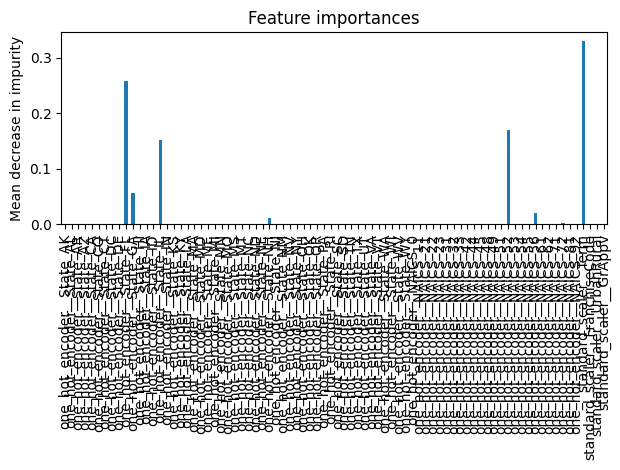

In [44]:
forest_importances = pd.Series(importances, index=index)

fig, ax = plt.subplots()
forest_importances.plot.bar(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

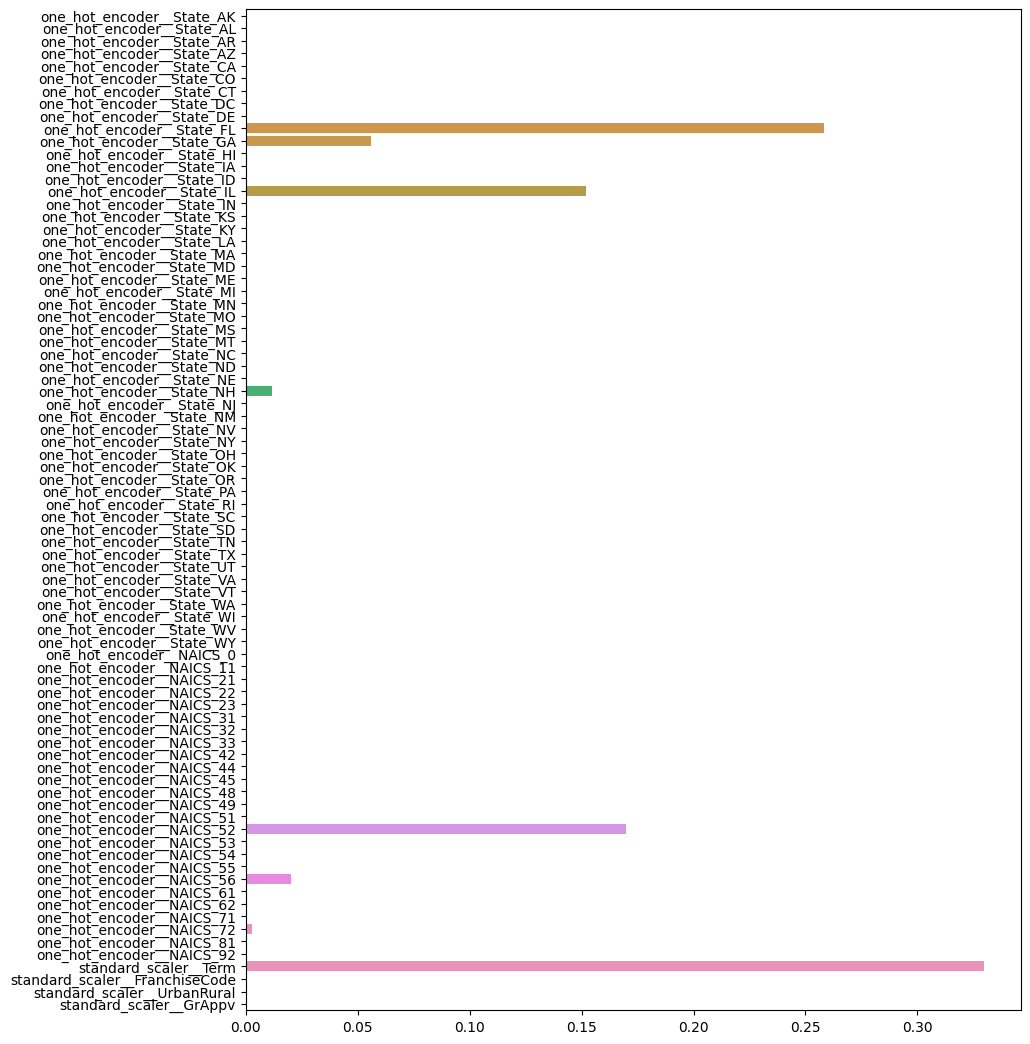

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(w = 10, h = 13)
sns.barplot(y = index, x = importances, ax=ax)
plt.show()

# logistic regression 